In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from scipy.signal import butter, lfilter, filtfilt
from scipy.interpolate import griddata
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from scipy.stats import pearsonr
from scipy.signal import savgol_filter

In [ ]:
pd.set_option('display.max_columns', None)
CSV_PATH = "/content/drive/MyDrive/CompNeuroNotebooks/Final Project/adhdata.csv"
FS = 128 # Sampling frequency
WINDOW_SEC = 4
OVERLAP = 0.5
SAMPLE_SIZE = 3000
TRAIN_SUBSET_SIZE = 300

# Select channels of interest
CHANNELS_OF_INTEREST = ['F3', 'Fz', 'F4', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'P4']
COORDS = {
    'Fp1': (-0.3, 0.9), 'Fp2': (0.3, 0.9),
    'F7': (-0.8, 0.6), 'F3': (-0.4, 0.6), 'Fz': (0, 0.6), 'F4': (0.4, 0.6), 'F8': (0.8, 0.6),
    'T7': (-0.9, 0), 'C3': (-0.4, 0), 'Cz': (0, 0), 'C4': (0.4, 0), 'T8': (0.9, 0),
    'P7': (-0.8, -0.6), 'P3': (-0.4, -0.6), 'Pz': (0, -0.6), 'P4': (0.4, -0.6), 'P8': (0.8, -0.6),
    'O1': (-0.3, -0.9), 'O2': (0.3, -0.9)
}

In [ ]:
# Data loader
def load_data(csv_path):
  try:
    df = pd.read_csv(csv_path)
  except FileNotFoundError:
    print(f"File not found: {csv_path}")
    return None, None, None, None

  def filter_signal(data):
    nyq = 0.5 * FS
    b, a = butter(4, [0.5/nyq, 50.0/nyq], btype='band')
    # clean_signal = filtfilt(b, a, signal)
    return filtfilt(b, a, data, axis=0)

  # Extract all channels
  available_channels = [c for c in CHANNELS_OF_INTEREST if c in df.columns]
  print(f"Found {len(available_channels)} channels: {available_channels}")

  classes = df['Class'].unique()
  print("Found classes: ", classes)

  total_samples = len(df)
  print(f"Total Samples: {total_samples}")

  # Extract signals
  raw_adhd = df[df['Class'] == classes[0]][available_channels].values
  raw_control = df[df['Class'] == classes[1]][available_channels].values

  # Filter
  clean_adhd = filter_signal(raw_adhd)
  clean_control = filter_signal(raw_control)

  print(f" - ADHD rows (Timepoints): {len(raw_adhd)}")
  print(f" - Control rows (Timepoints): {len(raw_control)}")

  return clean_adhd, clean_control, classes[0], classes[1], available_channels

In [ ]:
# Augmentation
def create_epochs(signal, label, time_window_in_sec, overlap):
  window_samples = int(FS * time_window_in_sec)
  step_samples = int(window_samples * (1 - overlap))

  epochs = []
  labels = []

  # If too short, attempt padding
  if len(signal) < window_samples:
    mult = (window_samples // len(signal)) + 2
    signal = np.tile(signal, (mult, 1))

  for i in range(0, len(signal) - window_samples, step_samples):
    chunk = signal[i:i + window_samples, :]
    if not np.isnan(chunk).any():
      epochs.append(chunk)
      labels.append(label)

  return np.array(epochs), np.array(labels)

In [ ]:
# Feature extraction
def extract_features_per_channel(epochs):
  # Epochs shape: (N_epochs, Time, Channels)
  # Output: (N_epochs, Channel * 5 features)
  features = []
  for epoch in epochs:
    row_features = []
    for ch in range(epoch.shape[1]):
      sig = epoch[:, ch]
      row_features.extend([
          np.std(sig),
          np.mean(sig**2),
          np.ptp(sig),
          np.mean(sig),
          np.max(np.abs(np.diff(sig)))
      ])
    features.append(row_features)
  return np.array(features)


In [ ]:
# Main
raw_adhd, raw_control, label_a, label_c, channels = load_data(CSV_PATH)

Found 9 channels: ['F3', 'Fz', 'F4', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'P4']
Found classes:  ['ADHD' 'Control']
Total Samples: 2166383
 - ADHD rows (Timepoints): 1207069
 - Control rows (Timepoints): 959314


In [ ]:
# Epoch creation (Augmentation)
X_a_epoch, y_a = create_epochs(raw_adhd, 0, WINDOW_SEC, OVERLAP)
X_c_epoch, y_c = create_epochs(raw_control, 1, WINDOW_SEC, OVERLAP)
print(f" Generated \n{len(X_a_epoch)} ADHD Epochs | {len(X_c_epoch)} Control Epochs")

 Generated 
4714 ADHD Epochs | 3746 Control Epochs


In [ ]:
# Feature extraction
# X_a_epoch_reshaped = X_a_epoch.reshape(X_a_epoch.shape[0], X_a_epoch.shape[1], 1)
# X_c_epoch_reshaped = X_c_epoch.reshape(X_c_epoch.shape[0], X_c_epoch.shape[1], 1)

X_a_feat = extract_features_per_channel(X_a_epoch)
X_c_feat = extract_features_per_channel(X_c_epoch)

X_all = np.vstack((X_a_feat, X_c_feat))
y_all = np.hstack((y_a, y_c))

In [ ]:
# Data scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

In [ ]:
# A. Stratified Sampling (Get a manageable subset)
if len(X_scaled) > SAMPLE_SIZE:
    # idx_a = np.random.choice(np.where(y_all==0)[0], SAMPLE_SIZE//2, replace=True)
    # idx_c = np.random.choice(np.where(y_all==1)[0], SAMPLE_SIZE//2, replace=True)

    idx = np.random.choice(len(X_scaled), SAMPLE_SIZE, replace=False)
    X_vis = X_scaled[idx]
    y_vis = y_all[idx]
else:
    X_vis = X_scaled
    y_vis = y_all

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vis, y_vis, test_size=0.2, random_state=42)

In [ ]:
# Classifiers and Decision boundaries
# Generate boundaries using PCA (2D)
pca = PCA(n_components=2)
X_trained_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(kernel='rbf', C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5)
}

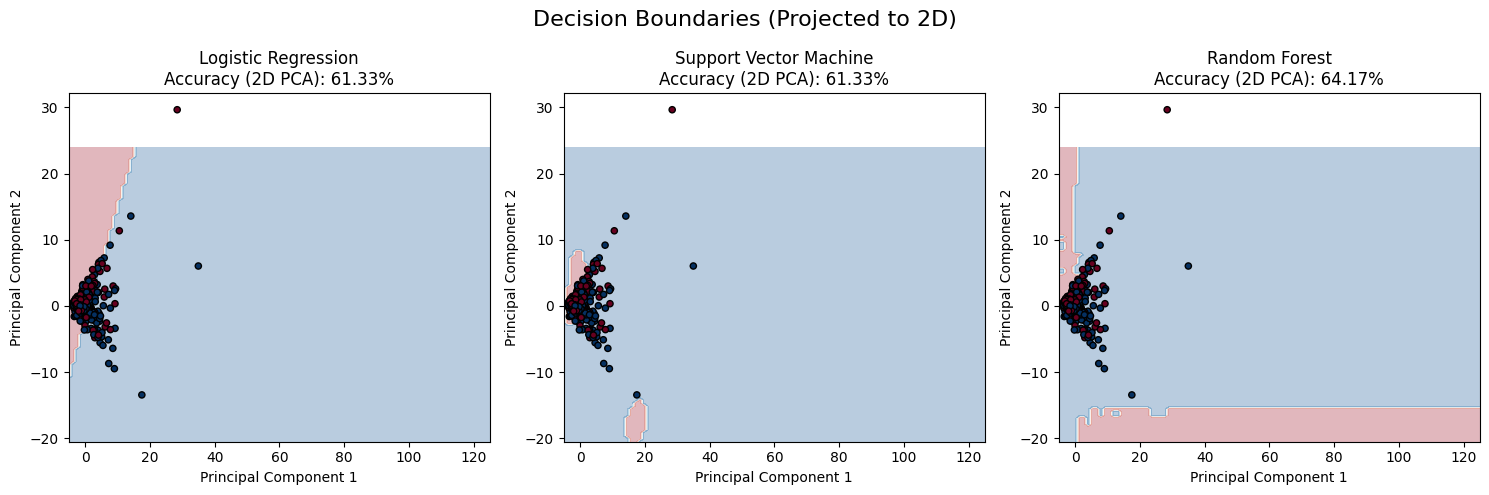

In [ ]:
# Visualise
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cm_bright = plt.cm.RdBu

for i, (name, clf) in enumerate(classifiers.items()):
  # Train the classifier on the PCA-transformed data for visualization
  clf.fit(X_trained_pca, y_train)
  score = clf.score(X_test_pca, y_test)

  DecisionBoundaryDisplay.from_estimator(
      clf,
      X_trained_pca,
      cmap=cm_bright,
      alpha=0.3,
      ax=axes[i],
      response_method='predict',
      grid_resolution=100
  )
  axes[i].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', s=20)
  axes[i].set_title(f"{name}\nAccuracy (2D PCA): {score*100:.2f}%")
  axes[i].set_xlabel('Principal Component 1')
  axes[i].set_ylabel('Principal Component 2')

fig.suptitle("Decision Boundaries (Projected to 2D)", fontsize=16)
plt.tight_layout()
plt.savefig('decision_boundaries_fucked.png')
plt.show()

In [ ]:
# @title Twins

In [ ]:
class ChannelTwin(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(1, 16), nn.Tanh(), nn.Linear(16, 1))
  def forward(self, x): return self.net(x)

In [ ]:
# Brain stability
def get_brain_stability(epochs, channel_names, desc_text):
  scores = []
  print(f"   Scanning {len(channel_names)} channels...")
  for i in tqdm(range(len(channel_names)), desc=desc_text):
    if len(epochs) > TRAIN_SUBSET_SIZE:
      indices = np.random.choice(len(epochs), TRAIN_SUBSET_SIZE, replace=False)
      subset = epochs[indices, :, i]
    else:
      subset = epochs[:, :, i]

    # Flatten channel data
    sig = epochs[:, :, i].flatten()
    sig = (sig - sig.mean()) / (sig.std() + 1e-6)

    # Train Twin on this channel's physics
    twin = ChannelTwin()
    opt = optim.Adam(twin.parameters(), lr=0.02)
    X_t = torch.FloatTensor(sig).view(-1, 1)

    # Fit
    for _ in range(30):
      opt.zero_grad()
      loss = nn.MSELoss()(twin(X_t[:-1]), X_t[1:])
      loss.backward(); opt.step()

    # Measure Instability (Drift from 0)
    curr = torch.tensor([[0.0]])
    drift = 0.0
    with torch.no_grad():
      for _ in range(100):
          nxt = twin(curr) + torch.randn(1, 1)*0.1
          drift += abs(nxt.item())
          curr = nxt
    scores.append(drift)
  return scores

In [ ]:
# Train twins
print("   -> Mapping Neurotypical Brain...")
scores_c = get_brain_stability(X_c_epoch, channels, 'Scanning Control Brain')

print("   -> Mapping ADHD Brain...")
scores_a = get_brain_stability(X_a_epoch, channels, 'Scanning ADHD Brain')

   -> Mapping Neurotypical Brain...
   Scanning 9 channels...


Scanning Control Brain:   0%|          | 0/9 [00:00<?, ?it/s]

   -> Mapping ADHD Brain...
   Scanning 9 channels...


Scanning ADHD Brain:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# Heads
def plot_head(ax, scores, title, vmin, vmax):
  x = [COORDS[ch][0] for ch in channels]; y = [COORDS[ch][1] for ch in channels]

  grid_x, grid_y = np.mgrid[-1.2:1.2:100j, -1.2:1.2:100j]
  grid_z = griddata((x, y), scores, (grid_x, grid_y), method='cubic', fill_value=np.mean(scores))

  im = ax.imshow(grid_z.T, extent=(-1.2,1.2,-1.2,1.2), origin='lower', cmap='jet', alpha=0.8, vmin=vmin, vmax=vmax)
  ax.scatter(x, y, c='k', s=20)
  ax.add_patch(plt.Circle((0,0), 1, color='k', fill=False, lw=2))
  ax.plot([-0.1, 0, 0.1], [0.98, 1.1, 0.98], 'k', lw=2) # Nose
  for i, txt in enumerate(channels): ax.text(x[i], y[i]+0.1, txt, fontsize=8, ha='center')
  ax.set_title(title); ax.axis('off')
  return im

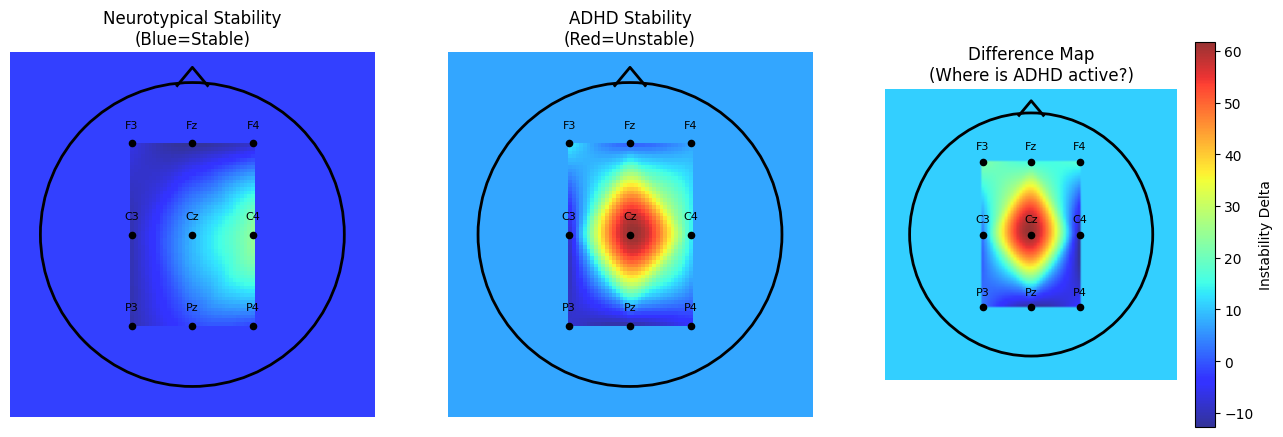

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
vmin, vmax = min(min(scores_c), min(scores_a)), max(max(scores_c), max(scores_a))

plot_head(axes[0], scores_c, "Neurotypical Stability\n(Blue=Stable)", vmin, vmax)
plot_head(axes[1], scores_a, "ADHD Stability\n(Red=Unstable)", vmin, vmax)

diff = np.array(scores_a) - np.array(scores_c)
im = plot_head(axes[2], diff, "Difference Map\n(Where is ADHD active?)", None, None)
plt.colorbar(im, ax=axes[2], label="Instability Delta")
plt.savefig("Brain Map")
plt.show()

In [ ]:
def run_advanced_interaction_analysis(ch1_name, ch2_name):
    """
    Detailed "Zoom-In" analysis of two specific channels.
    Generates Time-Series, Phase Portraits, and Sync Metrics.
    """
    print(f" Zooming in on interaction: {ch1_name} <--> {ch2_name} (with smoothing)...")

    # 1. Get Data indices
    try:
        idx1 = channels.index(ch1_name)
        idx2 = channels.index(ch2_name)
    except ValueError:
        print(" Error: Channel names not found in your processed list.")
        print(f"Available: {channels}")
        return

    # 2. Train 4 Twins (ADHD Ch1, ADHD Ch2, Control Ch1, Control Ch2)
    def train_twin(epochs, ch_idx):
        # Fast Subset Training
        if len(epochs) > TRAIN_SUBSET_SIZE:
            indices = np.random.choice(len(epochs), TRAIN_SUBSET_SIZE, replace=False)
            subset = epochs[indices, :, ch_idx]
        else:
            subset = epochs[:, :, ch_idx]

        sig = subset.flatten()
        sig = (sig - sig.mean()) / (sig.std() + 1e-6)

        twin = ChannelTwin()
        opt = optim.Adam(twin.parameters(), lr=0.02)
        X_t = torch.FloatTensor(sig).view(-1, 1)

        for _ in range(30):
            opt.zero_grad()
            loss = nn.MSELoss()(twin(X_t[:-1]), X_t[1:])
            loss.backward(); opt.step()
        return twin

    # Train all models
    twin_a1 = train_twin(X_a_epoch, idx1)
    twin_a2 = train_twin(X_a_epoch, idx2)
    twin_c1 = train_twin(X_c_epoch, idx1)
    twin_c2 = train_twin(X_c_epoch, idx2)

    # 3. The "Dream" (Simulate Interaction)
    def simulate_pair(model1, model2):
      path1, path2 = [], []
      curr1 = torch.tensor([[0.5]]) # Start Distracted
      curr2 = torch.tensor([[0.5]])

      with torch.no_grad():
          for _ in range(300):
              # Evolve both independently (visualizing their internal stability)
              nxt1 = model1(curr1) + torch.randn(1,1)*0.02
              nxt2 = model2(curr2) + torch.randn(1,1)*0.02

              path1.append(nxt1.item())
              path2.append(nxt2.item())
              curr1, curr2 = nxt1, nxt2
      return np.array(path1), np.array(path2)


    traj_a1, traj_a2 = simulate_pair(twin_a1, twin_a2)
    traj_c1, traj_c2 = simulate_pair(twin_c1, twin_c2)

    # Smoothing
    def smooth(y, window=15, poly=3):
      """
      Applies a Savitzky-Golay filter to remove jitter.
      """
      return savgol_filter(y, window, poly)

    # --- 4. ADVANCED PLOTTING ---
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(3, 2)

    # ROW 1: TIME SERIES (What you had before)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(traj_c1, color='blue', alpha=0.6, label=ch1_name)
    ax1.plot(traj_c2, color='cyan', alpha=0.6, label=ch2_name)
    ax1.set_title(f"Neurotypical: Time Response\n(Synced & Dampening)", fontsize=10)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(traj_a1, color='red', alpha=0.6, label=ch1_name)
    ax2.plot(traj_a2, color='orange', alpha=0.6, label=ch2_name)
    ax2.set_title(f"ADHD: Time Response\n(Chaotic & Drifting)", fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # ROW 2: PHASE PORTRAITS (The "Knot" - New & Informative)
    s_traj_c1, s_traj_c2 = smooth(traj_c1, 25), smooth(traj_c2, 25)
    s_traj_a1, s_traj_a2 = smooth(traj_a1, 25), smooth(traj_a2, 25)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(traj_c1, traj_c2, color='blue', alpha=0.5, lw=1)
    ax3.scatter(traj_c1[-1], traj_c2[-1], color='black', marker='x') # End point
    ax3.set_title(f"Neurotypical Phase Space ({ch1_name} vs {ch2_name})\n(Tight Attractor = Stability)", fontsize=10)
    ax3.set_xlabel(f"{ch1_name} State"); ax3.set_ylabel(f"{ch2_name} State")
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(traj_a1, traj_a2, color='red', alpha=0.5, lw=1)
    ax4.scatter(traj_a1[-1], traj_a2[-1], color='black', marker='x')
    ax4.set_title(f"ADHD Phase Space ({ch1_name} vs {ch2_name})\n(Loose Scribble = Instability)", fontsize=10)
    ax4.set_xlabel(f"{ch1_name} State"); ax4.set_ylabel(f"{ch2_name} State")
    ax4.grid(True, alpha=0.3)

    # ROW 3: SYNCHRONIZATION METRIC (Quantifying the disconnect)
    #
    def rolling_corr(x, y, window=30):
        return [pearsonr(x[i:i+window], y[i:i+window])[0] for i in range(len(x)-window)]

    corr_c = rolling_corr(traj_c1, traj_c2)
    corr_a = rolling_corr(traj_a1, traj_a2)

    ax5 = fig.add_subplot(gs[2, :])
    ax5.plot(corr_c, color='blue', label='Neurotypical Sync')
    ax5.plot(corr_a, color='red', label='ADHD Sync')
    ax5.set_title("Network Connectivity (Rolling Correlation)", fontsize=10)
    ax5.set_ylabel("Correlation (1.0 = Perfect Sync)")
    ax5.set_xlabel("Time Steps")
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{ch1_name}, {ch2_name} with smoothing")
    plt.show()

 Zooming in on interaction: F3 <--> F4 (with smoothing)...


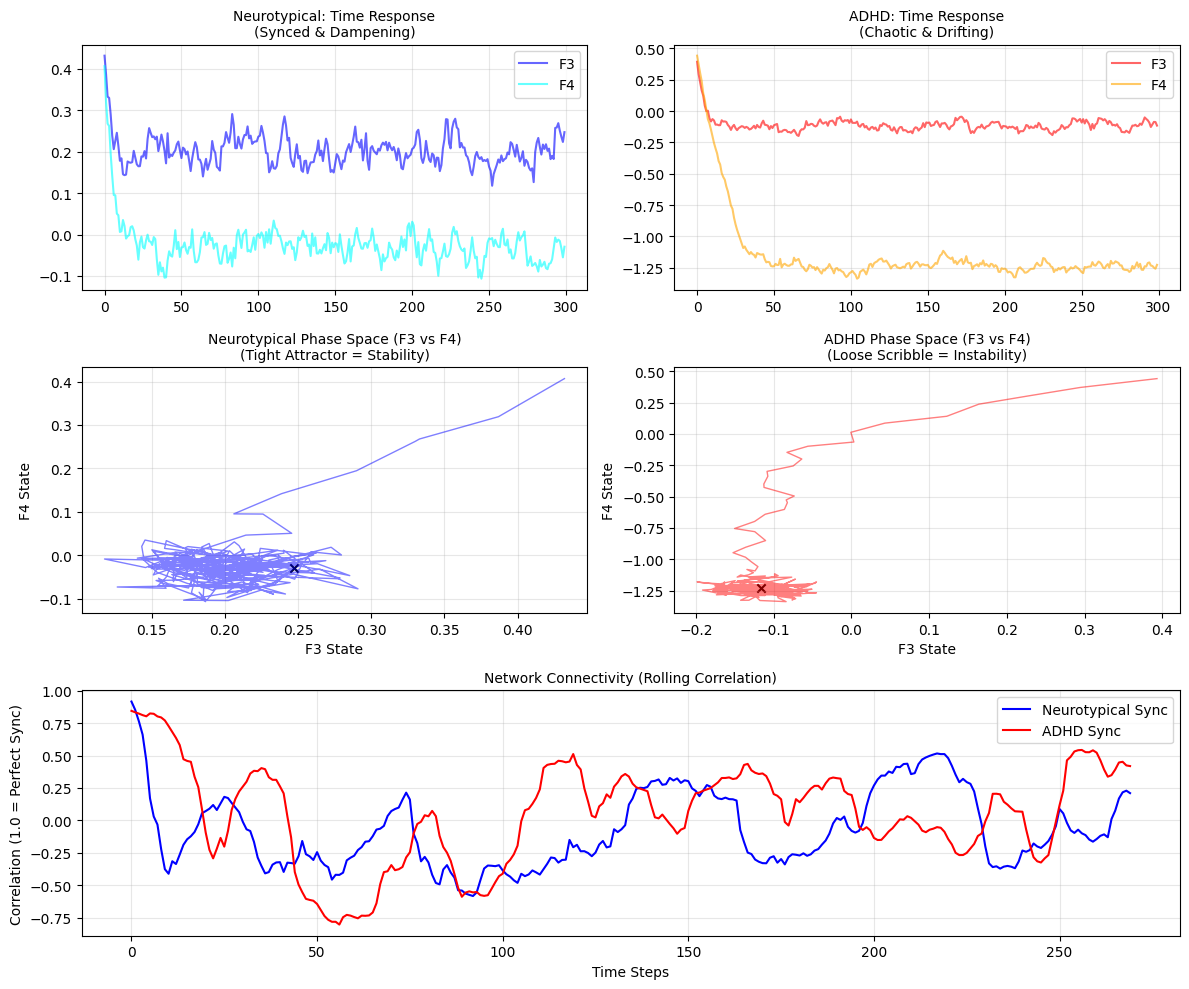

In [ ]:
run_advanced_interaction_analysis('F3', 'F4')

 Zooming in on interaction: Fz <--> Pz (with smoothing)...


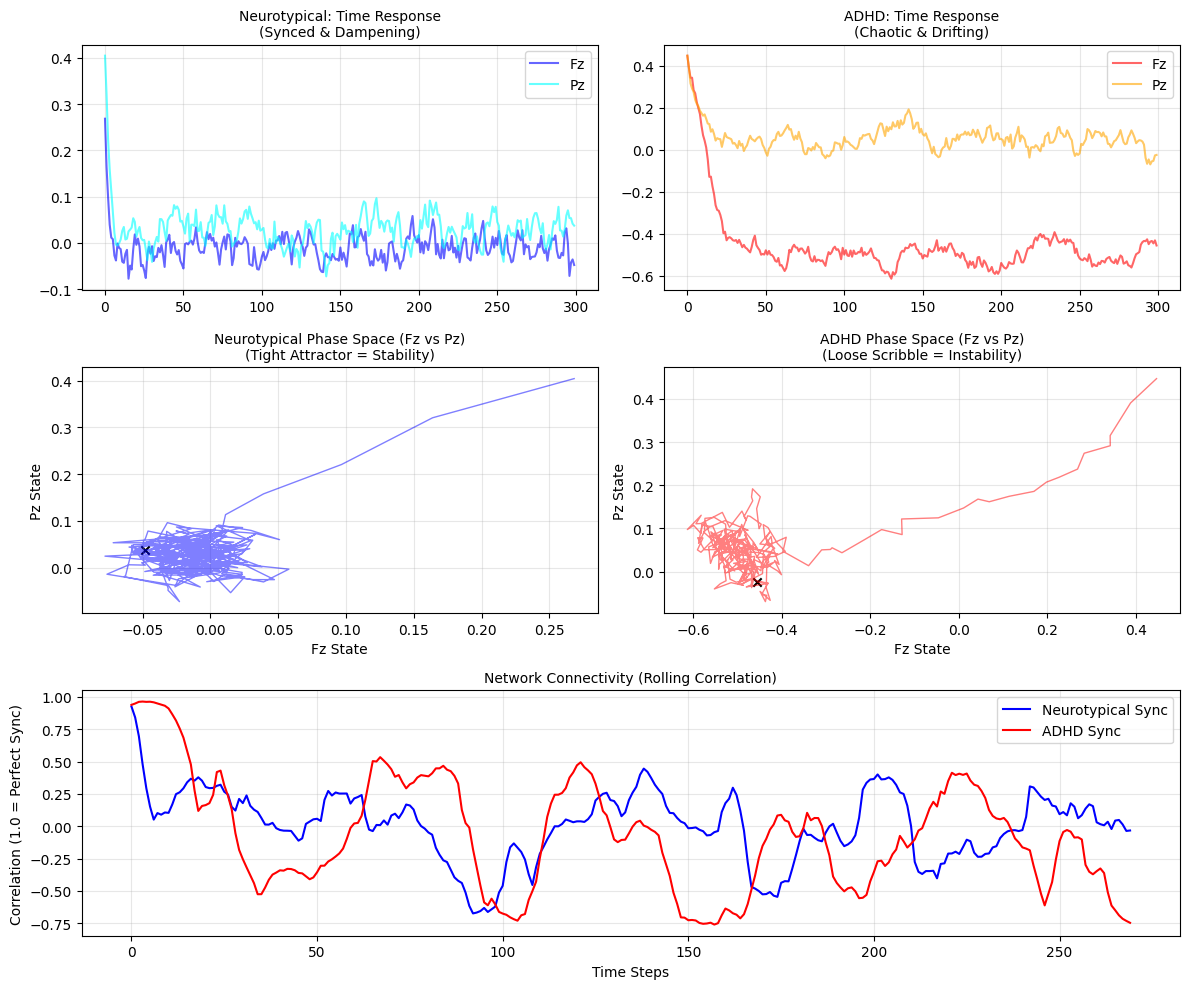

In [ ]:
run_advanced_interaction_analysis('Fz', 'Pz')

 Zooming in on interaction: C3 <--> C4 (with smoothing)...


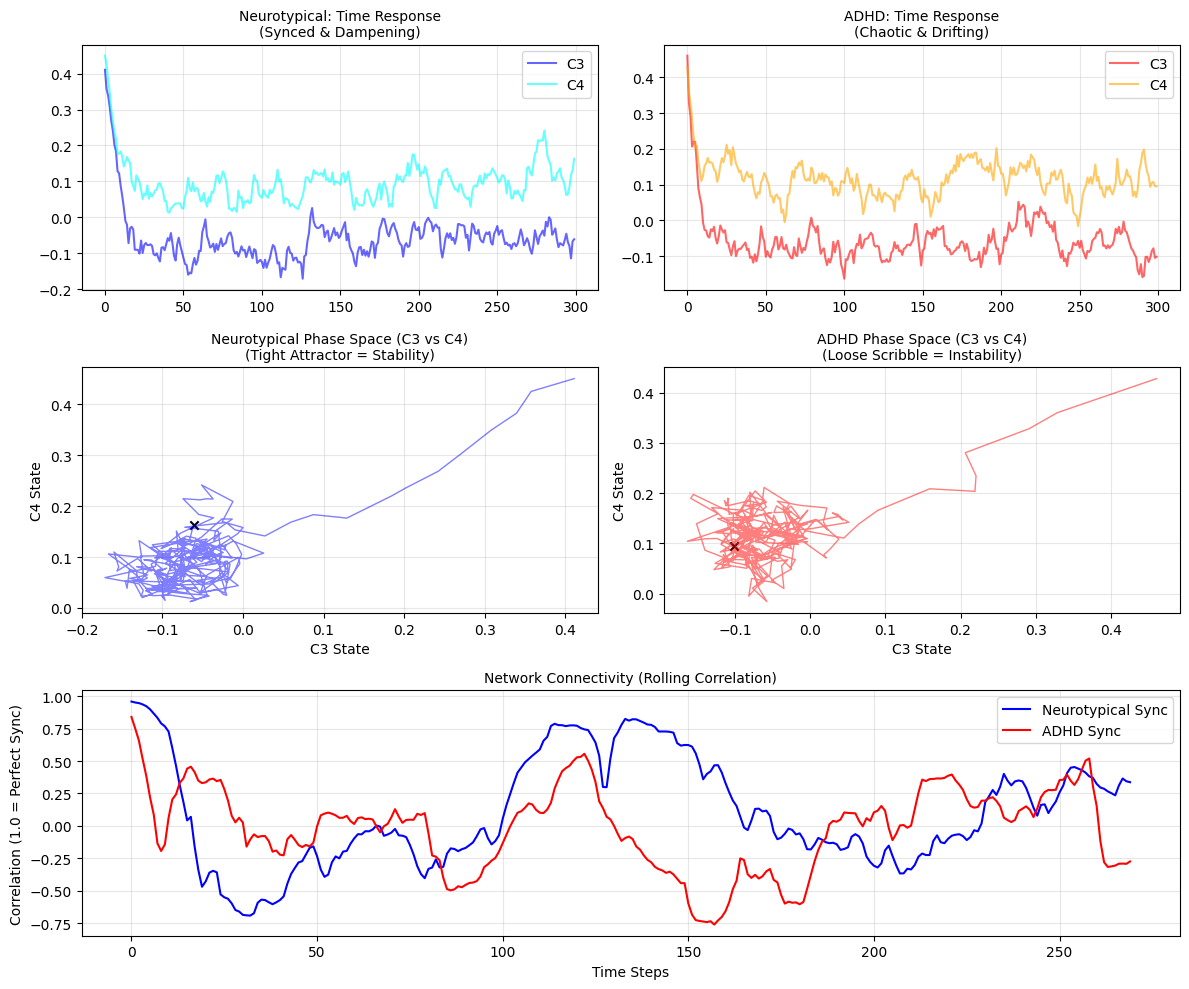

In [ ]:
run_advanced_interaction_analysis('C3', 'C4')